<a href="https://colab.research.google.com/github/surensnyper/login-lecture/blob/master/PA2_Yougnsun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

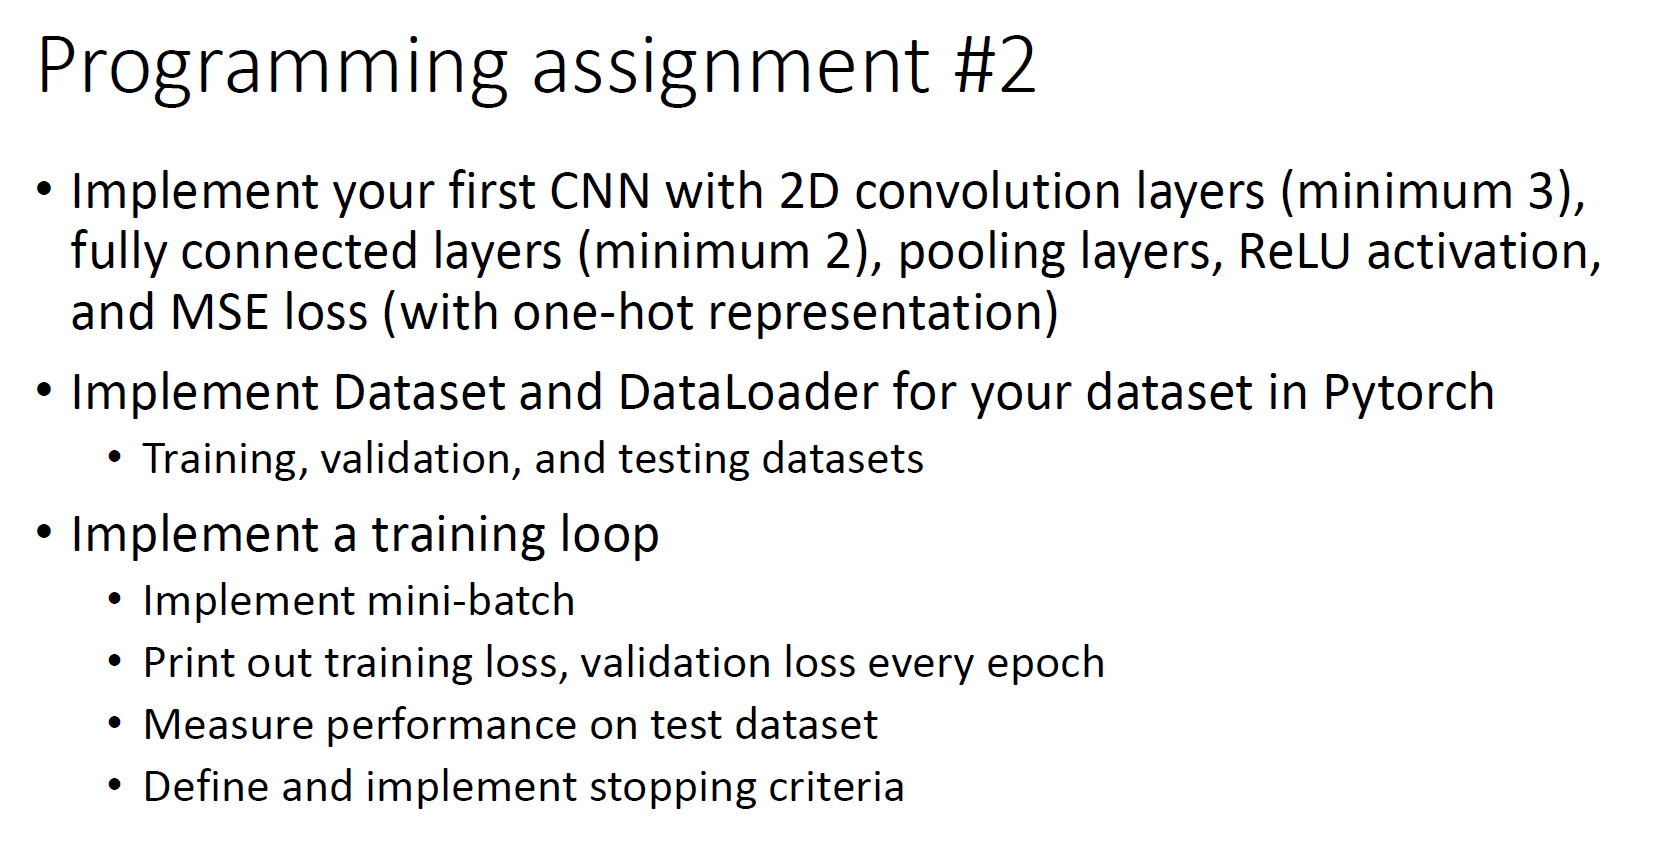

In [2]:
# Dataset: Cancer Data
# Histopathologic Cancer Detection
# https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

# How to import Kaggle data into Colab
# https://www.youtube.com/watch?v=yEXkEUqK52Q

! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
! mkdir ~/.kaggle

In [6]:
!cp /content/drive/MyDrive/Colab_Notebooks/Coursework/2022-Fall/CSC-792-Deep-learning/PA2/kaggle.json ~/.kaggle/kaggle.json

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download histopathologic-cancer-detection

100% 6.29G/6.31G [00:48<00:00, 169MB/s]
100% 6.31G/6.31G [00:48<00:00, 140MB/s]


In [9]:
!unzip histopathologic-cancer-detection.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d5e86165f63c57acdf9d23521f2b8070e0c.tif  
  inflating: train/fa2ffac7f7abed98942f6

In [10]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
# import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [11]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io

In [28]:
import matplotlib.pyplot as plt

In [12]:
class CancerDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.annotations) # 220,025 images

  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0]) # row = index, column = 0 (id of image)
    image = io.imread(img_path)
    label = torch.tensor(int(self.annotations.iloc[index, 1]))

    if self.transform:
      image = self.transform(image)
    return image, label

In [13]:
# Set Device (GPU / CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
# Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 64
num_epochs = 60

In [31]:
# Load Data
# Data link: https://drive.google.com/file/d/1t70aUIzFx7Ndyfw5GbX310daknJKm6DA/view?usp=sharing

dataset = CancerDataset(csv_file='/content/drive/MyDrive/Colab_Notebooks/Coursework/2022-Fall/CSC-792-Deep-learning/PA2/Dataset/train_labels.csv',
                        root_dir='/content/train/', 
                        transform = transforms.ToTensor())
len_data = len(dataset)
len_train_data = int(len_data * 0.8)
len_valid_data = int(len_data * 0.1)
len_test_data = len_data - len_train_data - len_valid_data

train_set, valid_set, test_set = torch.utils.data.random_split(dataset, [len_train_data, len_valid_data, len_test_data])
train_loader = DataLoader(dataset = train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset = valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_set, batch_size=batch_size, shuffle=True)

In [32]:
# Model
class CNN(nn.Module):
  def __init__(self, in_channels=3, num_classes=2):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    self.fc1 = nn.Linear(32*12*12, 1024)
    self.fc2 = nn.Linear(1024, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.maxpool(x)
    x = F.relu(self.conv2(x))
    x = self.maxpool(x)
    x = F.relu(self.conv3(x))
    x = self.maxpool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc1(x)
    x = self.fc2(x)

    return x


In [33]:
model = CNN()

In [37]:
# Loss function definition and Optimizer for minimizing loss
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
# Check Accuracy on Training & Test to see how good our model

def check_accuracy(loader, model):
  
  num_correct = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device)
      y = y.to(device=device)
      
      scores = model(x) 
      _, predictions = scores.max(1) 
      num_correct += (predictions == y).sum()
      num_samples += predictions.size(0) 
    
    accuracy = float(num_correct)/float(num_samples)*100
    return num_correct, num_samples, accuracy
    
  
  model.train()

In [43]:
# Early Stopping Related Parameters
best_valid_loss = 10 ** 9 # Initialized with big number
patience_limit = 2 # The number of epochs to be compared with valid loss
patience_check = 0 # The number of epochs that the valid loss is not improved

# Traning Network
for epoch in range(num_epochs):
  train_losses = []
  valid_losses = []

  for batch_idx, (data, targets) in enumerate(train_loader): # data: images / targets: labels
    # Get data to Cuda if possible
    data = data.to(device=device)
    targets = F.one_hot(targets, num_classes=2)
    targets = targets.to(device=device)
    model = model.to(device=device)
    
    # Forward Training
    scores = model(data)
    
    # print(f'socres: {scores}')
    # print(f'targets: {targets}')


    loss = criterion(scores, targets.float())

    train_losses.append(loss.item())
    valid_losses.append(loss.item())

    # Backward Training
    optimizer.zero_grad() # Gradient initialization as 0
    loss.backward()

    # Gradient descent or adam step
    optimizer.step()
  
  # Cost (Losses)
  train_loss = sum(train_losses)/len(train_loader)
  valid_loss = sum(valid_losses)/len(valid_loader)

  # Accuracy
  num_correct_train, num_samples_train, accuracy_train = check_accuracy(train_loader, model)
  num_correct_valid, num_samples_valid, accuracy_valid = check_accuracy(valid_loader, model)
  num_correct_test, num_samples_test, accuracy_test = check_accuracy(test_loader, model)

  # Early Stopping
  if valid_loss > best_valid_loss: # When Loss is improved
    patience_check += 1
    if patience_check >= patience_limit:
      print('Training Stops Early!')
      break
  else: # When Loss is not improved
    best_valid_loss = valid_loss
    patience_check = 0

  print(f'Cost at Epoch {epoch} == Train Cost: {train_loss:.4f}    Valid Cost: {best_valid_loss:.4f}')
  print(f'   Accuracy: Train {accuracy_train:.2f} ({num_correct_train}/{num_samples_train})   Validation {accuracy_valid:.2f} ({num_correct_valid}/{num_samples_valid})   Test {accuracy_test:.2f} ({num_correct_test}/{num_samples_test})')

Cost at Epoch 0 == Train Cost: 0.1018    Valid Cost: 0.8142
   Accuracy: Train 87.70 (154374/176020)   Validation 87.12 (19169/22002)   Test 86.92 (19124/22003)
Cost at Epoch 1 == Train Cost: 0.1003    Valid Cost: 0.8023
   Accuracy: Train 87.89 (154696/176020)   Validation 87.32 (19213/22002)   Test 86.94 (19129/22003)
Cost at Epoch 2 == Train Cost: 0.0985    Valid Cost: 0.7878
   Accuracy: Train 86.77 (152736/176020)   Validation 86.16 (18957/22002)   Test 86.13 (18952/22003)
Cost at Epoch 3 == Train Cost: 0.0969    Valid Cost: 0.7749
   Accuracy: Train 88.55 (155863/176020)   Validation 87.78 (19313/22002)   Test 87.52 (19256/22003)
Cost at Epoch 4 == Train Cost: 0.0955    Valid Cost: 0.7638
   Accuracy: Train 88.63 (156008/176020)   Validation 87.96 (19354/22002)   Test 87.77 (19313/22003)
Cost at Epoch 5 == Train Cost: 0.0944    Valid Cost: 0.7552
   Accuracy: Train 87.41 (153858/176020)   Validation 86.91 (19121/22002)   Test 86.67 (19069/22003)
Cost at Epoch 6 == Train Cost: 0.0